In [29]:
import numpy as np

In [30]:
class Dense_Layer:
    def __init__(self,ninputs,nneurons,l1_w=0,l1_b=0,l2_w=0,l2_b=0):
        # Initialising weights and biases
        self.weights = 0.01 * np.random.randn(ninputs,nneurons)
        self.biases = np.zeros((1,nneurons))
        # Regularization
        self.l1_w = l1_w
        self.l1_b = l1_b
        self.l2_w = l2_w
        self.l2_b = l2_b
        
    # Forward Propagation    
    def forward(self,inputs,training):
        self.output = np.dot(inputs,self.weights) + self.biases
        self.inputs = inputs
    
    # Backpropagation
    def backward(self,dvalues):
        self.dinputs = np.dot(dvalues,self.weights.T)
        self.dweights = np.dot(self.inputs.T,dvalues)
        self.dbiases = np.sum(dvalues,axis=0,keepdims=True)
        
        if self.l1_w > 0:
            dl1w = np.ones_like(self.weights)
            dl1w[self.weights < 0] = -1
            self.dweights += dl1w
        if self.l1_b > 0:
            dl1b = np.ones_like(self.biases)
            dl1b[self.biases < 0] = -1
            self.dbiases += sl1b
        if self.l2_w > 0:
            self.dweights += self.weights * 2 * self.l2_w
        if self.l2_b > 0:
            self.dbiases += self.biases * 2 * self.l2_b

In [31]:
class Dropout_layer:
    def __init__(self,drop_rate=0):
        self.drop_rate = 1 - drop_rate
    def forward(self,inputs,training):
        if not training:
            self.output = input.copy()
            return
        self.dropmask = np.random.binomial(1,self.drop_rate,size =inputs.shape)/(self.drop_rate)
        self.output = inputs * self.dropmask
    def backward(self,dvalues):
        self.dinputs = dvalues * self.dropmask

In [44]:
class Activation_Relu:
    def forward(self,inputs,training):
        self.output = np.maximum(0,inputs)
        self.inputs = inputs
    
    def backward(self,dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0
        

In [33]:
class Activation_Sigmoid:
    def forward(self,inputs,training):
        self.inputs= inputs
        self.outputs = 1/(1+np.exp(-inputs))
    def backward(self,dvalues):
        self.dinputs = dvalues * self.outputs * (1 - self.outputs)

In [34]:
class Loss_BinaryCrossentropy():
    def calculate(self, output, y):
        # Calculate sample losses
        sample_losses = self.forward(output, y)
        # Calculate mean loss
        data_loss = np.mean(sample_losses)
        # Return loss
        return data_loss

    def regularization_loss(self):
        
        loss = 0
        for layer in self.trainable_layers:
            if layer.l1_w > 0:
                loss += layer.l1_w * np.sum(np.abs(layer.weights))
            if layer.l1_b > 0:
                loss += layer.l1_b * np.sum(np.abs(layer.biases))
            if layer.l2_w > 0:
                loss += layer.l2_w * np.sum(layer.weights * layer.weights)
            if layer.l2_b > 0:
                loss += layer.l2_b * np.sum(layer.biases * layer.biases)
        
        return loss
    
    def remember_trainable_layers(self, trainable_layers):
        self.trainable_layers = trainable_layers
    
    # Forward pass
    def forward(self, y_pred, y_true):
        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        # Calculate sample-wise loss
        sample_losses = -(y_true * np.log(y_pred_clipped) +
        (1 - y_true) * np.log(1 - y_pred_clipped))
        sample_losses = np.mean(sample_losses, axis=-1)
        # Return losses
        return sample_losses
        # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        # Number of outputs in every sample
        # We'll use the first sample to count them
        outputs = len(dvalues[0])
        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        clipped_dvalues = np.clip(dvalues, 1e-7, 1 - 1e-7)
        # Calculate gradient
        self.dinputs = -(y_true / clipped_dvalues -
        (1 - y_true) / (1 - clipped_dvalues)) / outputs
        # Normalize gradient
        self.dinputs = self.dinputs / samples

In [54]:
class Activation_Softmax:
    def forward(self,inputs,y_true):
        expvals = np.exp(inputs - np.max(inputs, axis=1,
        keepdims=True) )
        self.output = expvals/np.sum(expvals,axis=1,keepdims=True)
        
    def predictions(self, outputs):
        return np.argmax(outputs, axis=1)

In [52]:
class CrossEntropyLoss:
    def forward(self, y_pred, y_true):
        # Number of samples in a batch
        samples = len(y_pred)
        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        # Probabilities for target values -
        # only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
            range(samples),
            y_true
            ]
        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
            y_pred_clipped * y_true,
            axis=1
            )
        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods
    
    def calculate(self, output, y, *, regularization=False):
        # Calculate sample losses
        sample_losses = self.forward(output, y)
        # Calculate mean loss
        data_loss = np.mean(sample_losses)
        # If just data loss - return it
        if not regularization:
            return data_loss
        # Return the data and regularization losses
        return data_loss, self.regularization_loss()
        
        return np.mean(-np.log(y_pred[range(len(y_pred)),y_true]))
    def regularization_loss(self):
        
        loss = 0
        for layer in self.trainable_layers:
            if layer.l1_w > 0:
                loss += layer.l1_w * np.sum(np.abs(layer.weights))
            if layer.l1_b > 0:
                loss += layer.l1_b * np.sum(np.abs(layer.biases))
            if layer.l2_w > 0:
                loss += layer.l2_w * np.sum(layer.weights * layer.weights)
            if layer.l2_b > 0:
                loss += layer.l2_b * np.sum(layer.biases * layer.biases)
        
        return loss
    
    def remember_trainable_layers(self, trainable_layers):
        self.trainable_layers = trainable_layers

In [37]:
class Activation_softmax_cross_entropy:
#     def __init__(self):
#         self.activation = Activation_Softmax()
#         self.lossfunc = CrossEntropyLoss()
    
#     def forward(self,inputs,y_true):
#         self.activation.forward(inputs,y_true)
#         self.output = self.activation.output
#         return self.lossfunc.calculate(self.output,y_true)
    
    def backward(self,dvalues,y_true):
        samples = len(y_true)
        
        # Turning one hot encoded arrays to sparse vectors
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true,axis=1)
        
        self.dinputs = dvalues.copy()
        self.dinputs[range(samples),y_true] -= 1
        
        self.dinputs/=samples

In [38]:
class SGD_Optimizer:
    def __init__(self,lr=1,decay_rate=0.1,momentum=0.):
        self.initiallr = lr
        self.currentlr = lr
        self.decay_rate = decay_rate
        self.iterations = 0
        self.momentum = momentum
    
    def pre_update(self):
        self.currentlr = self.initiallr * (1/(1+(self.decay_rate * self.iterations)))

    def update_params(self,layer):
        
        if self.momentum:
            # if we don't have momentum arrays create them
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                
                layer.bias_momentums = np.zeros_like(layer.biases)
            
            weight_updates = \
                self.momentum * layer.weight_momentums - self.currentlr * layer.dweights
            layer.weight_momentums = weight_updates
            
            bias_updates = \
                self.momentum * layer.bias_momentums - self.currentlr * layer.dbiases
            layer.bias_momentums = bias_updates
            
        else:
            weight_updates = -self.currentlr * layer.dweights
            bias_updates = -self.currentlr * layer.dbiases
                
        
        layer.weights += weight_updates
        layer.biases += bias_updates
        
    def post_update(self):
        self.iterations += 1

In [39]:
class Adagrad_Optimizer:
    def __init__(self,lr=1,decay_rate=0,epsilon = 1e-7):
        self.initiallr = lr
        self.currentlr = lr
        self.decay_rate = decay_rate
        self.iterations = 0
        self.epsilon = epsilon
    
    def pre_update(self):
        self.currentlr = self.initiallr * (1/(1+(self.decay_rate * self.iterations)))

    def update_params(self,layer):
        
        if not hasattr(layer,'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
        
        layer.weight_cache += (layer.dweights ** 2)
        layer.bias_cache += (layer.dbiases ** 2)
        
        layer.weights += - self.currentlr * layer.dweights  / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.currentlr * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)
        
    def post_update(self):
        self.iterations += 1

In [40]:
class RMSProp_Optimizer:
    def __init__(self,lr=0.001,decay_rate=0,epsilon = 1e-7,rho=0.9):
        self.initiallr = lr
        self.currentlr = lr
        self.decay_rate = decay_rate
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho
    
    def pre_update(self):
        self.currentlr = self.initiallr * (1/(1+(self.decay_rate * self.iterations)))

    def update_params(self,layer):
        
        if not hasattr(layer,'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
        
        layer.weight_cache = layer.weight_cache * self.rho + (1-self.rho) * (layer.dweights ** 2)
        layer.bias_cache = layer.bias_cache * self.rho + (1-self.rho) * (layer.dbiases ** 2)
        
        layer.weights += - self.currentlr * layer.dweights  / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.currentlr * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)
        
    def post_update(self):
        self.iterations += 1

In [41]:
class Adam_Optimizer:
    def __init__(self,lr=0.001,decay_rate=0,epsilon= 1e-7,beta1=0.9,beta2=0.999):
        self.initiallr = lr
        self.currentlr = lr
        self.decay_rate = decay_rate
        self.iterations = 0
        self.epsilon = epsilon
        self.beta1 = beta1
        self.beta2 = beta2
    
    def pre_update(self):
        self.currentlr = self.initiallr * (1/(1+(self.decay_rate * self.iterations)))

    def update_params(self,layer):
        
        if not hasattr(layer,'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
            layer.weight_momentum = np.zeros_like(layer.weights)
            layer.bias_momentum = np.zeros_like(layer.biases)
            
        layer.weight_momentum = self.beta1 * layer.weight_momentum + (1-self.beta1) * layer.dweights
        layer.bias_momentum = self.beta1 * layer.bias_momentum + (1 - self.beta1) * layer.dbiases
        
        layer.weight_momentum_prime = layer.weight_momentum / (1 - self.beta1 ** (self.iterations + 1))
        layer.bias_momentum_prime = layer.bias_momentum / (1 - self.beta1 ** (self.iterations + 1))
        
        layer.weight_cache = layer.weight_cache * self.beta2 + (1-self.beta2) * (layer.dweights ** 2)
        layer.bias_cache = layer.bias_cache * self.beta2 + (1-self.beta2) * (layer.dbiases ** 2)
        
        layer.weight_cache_prime = layer.weight_cache / (1 - self.beta2 ** (self.iterations + 1))
        layer.bias_cache_prime = layer.bias_cache / (1 - self.beta2 ** (self.iterations + 1))

        layer.weights += - self.currentlr * layer.weight_momentum_prime  / (np.sqrt(layer.weight_cache_prime) + self.epsilon)
        layer.biases += -self.currentlr * layer.bias_momentum_prime / (np.sqrt(layer.bias_cache_prime) + self.epsilon)
        
    def post_update(self):
        self.iterations += 1

In [19]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles

In [20]:
X,y = make_circles(n_samples=1000,noise=.05)

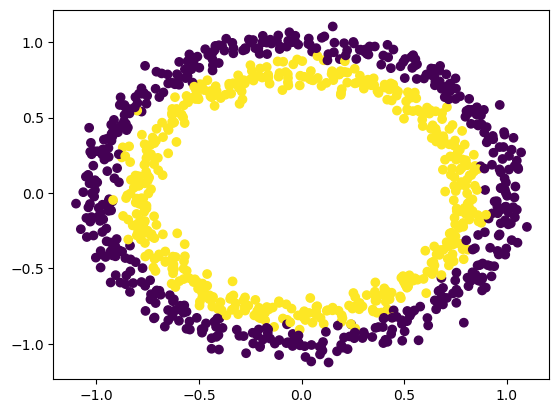

In [18]:
plt.scatter(X[:,0],X[:,1],c=y)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
...     X, y, test_size=0.33, random_state=42)

In [17]:
layer1 = Dense_Layer(2,64)
act = Activation_Relu()
layer2 = Dense_Layer(64,2)
actloss = Activation_softmax_cross_entropy()
optimizer = SGD_Optimizer(1,decay_rate=1e-3,momentum=0.5)

for epoch in range(1001):
    layer1.forward(X_train)
    act.forward(layer1.output)
    layer2.forward(act.output)
    loss = actloss.forward(layer2.output,y_train)
    
    y_pred = np.argmax(actloss.output,axis=1)
    
    acc = np.mean(y_pred == y_train)
    if epoch % 100 == 0:
        print("Epoch : ",epoch, " Accuracy : ",acc, " Loss : ",loss)
    
    actloss.backward(actloss.output,y_train)
    layer2.backward(actloss.dinputs)
    act.backward(layer2.dinputs)
    layer1.backward(act.dinputs)

    optimizer.update_params(layer1)
    optimizer.update_params(layer2)

Epoch :  0  Accuracy :  0.5074626865671642  Loss :  0.6931375535784944
Epoch :  100  Accuracy :  0.935820895522388  Loss :  0.5051123645703605
Epoch :  200  Accuracy :  0.9850746268656716  Loss :  0.1353215879916105
Epoch :  300  Accuracy :  0.9865671641791045  Loss :  0.07037692852899127
Epoch :  400  Accuracy :  0.9880597014925373  Loss :  0.0527870444533208
Epoch :  500  Accuracy :  0.9880597014925373  Loss :  0.04503055736814187
Epoch :  600  Accuracy :  0.9880597014925373  Loss :  0.04072176763583506
Epoch :  700  Accuracy :  0.9865671641791045  Loss :  0.0379726970879829
Epoch :  800  Accuracy :  0.9865671641791045  Loss :  0.03604849220735641
Epoch :  900  Accuracy :  0.9865671641791045  Loss :  0.03464716296561357
Epoch :  1000  Accuracy :  0.9865671641791045  Loss :  0.033587268101153825


In [15]:
import nnfs
from nnfs.datasets import spiral_data

In [92]:
np.random.seed(0)

In [27]:
X,y = spiral_data(samples=100,classes=3)

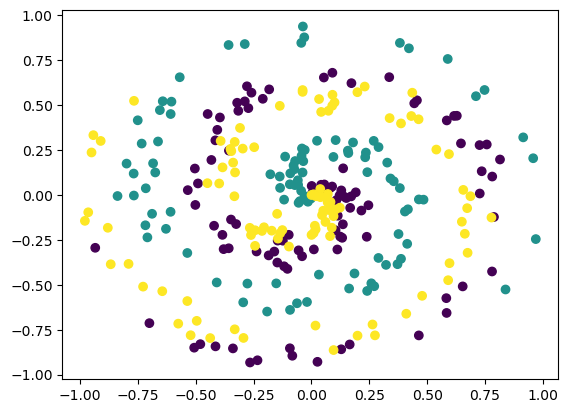

In [28]:
plt.scatter(X[:,0],X[:,1],c=y)

# SGD with momentum

In [50]:
layer1 = Dense_Layer(2,64)
act = Activation_Relu()
layer2 = Dense_Layer(64,3)
actloss = Activation_softmax_cross_entropy()
optimizer = SGD_Optimizer(1,decay_rate=0.001,momentum=0.9)

for epoch in range(10001):
    layer1.forward(X)
    act.forward(layer1.output)
    layer2.forward(act.output)
    loss = actloss.forward(layer2.output,y)
    
    y_pred = np.argmax(actloss.output,axis=1)
    
    acc = np.mean(y_pred == y)
    if epoch % 1000 == 0:
        print("Epoch : ",epoch, " Accuracy : ",acc, " Loss : ",loss)
    
    actloss.backward(actloss.output,y)
    layer2.backward(actloss.dinputs)
    act.backward(layer2.dinputs)
    layer1.backward(act.dinputs)

    optimizer.pre_update()
    optimizer.update_params(layer1)
    optimizer.update_params(layer2)
    optimizer.post_update()

Epoch :  0  Accuracy :  0.25  Loss :  1.0986372020152781
Epoch :  1000  Accuracy :  0.8833333333333333  Loss :  0.31818374461628013
Epoch :  2000  Accuracy :  0.91  Loss :  0.255988447840704
Epoch :  3000  Accuracy :  0.9233333333333333  Loss :  0.20598169799390997
Epoch :  4000  Accuracy :  0.9233333333333333  Loss :  0.19137998896808828
Epoch :  5000  Accuracy :  0.9233333333333333  Loss :  0.1841520273543525
Epoch :  6000  Accuracy :  0.9266666666666666  Loss :  0.1791384304261479
Epoch :  7000  Accuracy :  0.93  Loss :  0.17335565949661175
Epoch :  8000  Accuracy :  0.93  Loss :  0.16845797046570732
Epoch :  9000  Accuracy :  0.93  Loss :  0.16587541227451402
Epoch :  10000  Accuracy :  0.93  Loss :  0.1639515431829476


# Adagrad

In [53]:
layer1 = Dense_Layer(2,64)
act = Activation_Relu()
layer2 = Dense_Layer(64,3)
actloss = Activation_softmax_cross_entropy()
optimizer = Adagrad_Optimizer(lr=1,decay_rate=1e-4)

for epoch in range(10001):
    layer1.forward(X)
    act.forward(layer1.output)
    layer2.forward(act.output)
    loss = actloss.forward(layer2.output,y)
    
    y_pred = np.argmax(actloss.output,axis=1)
    
    acc = np.mean(y_pred == y)
    if epoch % 1000 == 0:
        print("Epoch : ",epoch, " Accuracy : ",acc, " Loss : ",loss)
    
    actloss.backward(actloss.output,y)
    layer2.backward(actloss.dinputs)
    act.backward(layer2.dinputs)
    layer1.backward(act.dinputs)

    optimizer.pre_update()
    optimizer.update_params(layer1)
    optimizer.update_params(layer2)
    optimizer.post_update()

Epoch :  0  Accuracy :  0.3233333333333333  Loss :  1.0986013616561447
Epoch :  1000  Accuracy :  0.7333333333333333  Loss :  0.5930440559873272
Epoch :  2000  Accuracy :  0.8133333333333334  Loss :  0.46962651610390843
Epoch :  3000  Accuracy :  0.8466666666666667  Loss :  0.41036505017795594
Epoch :  4000  Accuracy :  0.86  Loss :  0.34586911093143535
Epoch :  5000  Accuracy :  0.89  Loss :  0.30212404438224716
Epoch :  6000  Accuracy :  0.91  Loss :  0.2677735328596295
Epoch :  7000  Accuracy :  0.9133333333333333  Loss :  0.24792456155563494
Epoch :  8000  Accuracy :  0.9133333333333333  Loss :  0.23240392431921209
Epoch :  9000  Accuracy :  0.92  Loss :  0.22080468678910822
Epoch :  10000  Accuracy :  0.92  Loss :  0.2118743496390051


# RMSProp

In [77]:
layer1 = Dense_Layer(2,64)
act = Activation_Relu()
layer2 = Dense_Layer(64,3)
actloss = Activation_softmax_cross_entropy()
optimizer = RMSProp_Optimizer(lr=0.02,decay_rate=1e-5,rho=0.999)

for epoch in range(10001):
    layer1.forward(X)
    act.forward(layer1.output)
    layer2.forward(act.output)
    loss = actloss.forward(layer2.output,y)
    
    y_pred = np.argmax(actloss.output,axis=1)
    
    acc = np.mean(y_pred == y)
    if epoch % 1000 == 0:
        print("Epoch : ",epoch, " Accuracy : ",acc, " Loss : ",loss)
    
    actloss.backward(actloss.output,y)
    layer2.backward(actloss.dinputs)
    act.backward(layer2.dinputs)
    layer1.backward(act.dinputs)

    optimizer.pre_update()
    optimizer.update_params(layer1)
    optimizer.update_params(layer2)
    optimizer.post_update()

Epoch :  0  Accuracy :  0.2833333333333333  Loss :  1.0986126393243418
Epoch :  1000  Accuracy :  0.7366666666666667  Loss :  0.5426056614684285
Epoch :  2000  Accuracy :  0.8133333333333334  Loss :  0.4042984774766524
Epoch :  3000  Accuracy :  0.8466666666666667  Loss :  0.34589540744404756
Epoch :  4000  Accuracy :  0.8766666666666667  Loss :  0.3037880406746893
Epoch :  5000  Accuracy :  0.8833333333333333  Loss :  0.2883207195338394
Epoch :  6000  Accuracy :  0.89  Loss :  0.2638215173833059
Epoch :  7000  Accuracy :  0.8866666666666667  Loss :  0.23996465410414097
Epoch :  8000  Accuracy :  0.9  Loss :  0.2235633864107476
Epoch :  9000  Accuracy :  0.9066666666666666  Loss :  0.21138352851770262
Epoch :  10000  Accuracy :  0.9166666666666666  Loss :  0.20155813031548667


# Adam

In [216]:
layer1 = Dense_Layer(2,64)
act = Activation_Relu()
layer2 = Dense_Layer(64,3)
actloss = Activation_softmax_cross_entropy()
optimizer = Adam_Optimizer(lr=0.05,decay_rate=5e-7)

for epoch in range(10001):
    layer1.forward(X)
    act.forward(layer1.output)
    layer2.forward(act.output)
    loss = actloss.forward(layer2.output,y)
    
    y_pred = np.argmax(actloss.output,axis=1)
    
    acc = np.mean(y_pred == y)
    if epoch % 1000 == 0:
        print("Epoch : ",epoch, " Accuracy : ",acc, " Loss : ",loss)
    
    actloss.backward(actloss.output,y)
    layer2.backward(actloss.dinputs)
    act.backward(layer2.dinputs)
    layer1.backward(act.dinputs)

    optimizer.pre_update()
    optimizer.update_params(layer1)
    optimizer.update_params(layer2)
    optimizer.post_update()

Epoch :  0  Accuracy :  0.3333333333333333  Loss :  1.0986082325091153
Epoch :  1000  Accuracy :  0.9233333333333333  Loss :  0.18690389313982483
Epoch :  2000  Accuracy :  0.96  Loss :  0.13332780129487948
Epoch :  3000  Accuracy :  0.97  Loss :  0.10929691223502365
Epoch :  4000  Accuracy :  0.9766666666666667  Loss :  0.0935965551894672
Epoch :  5000  Accuracy :  0.9766666666666667  Loss :  0.08837522493951153
Epoch :  6000  Accuracy :  0.9766666666666667  Loss :  0.0833746357722843
Epoch :  7000  Accuracy :  0.9733333333333334  Loss :  0.07836283656354763
Epoch :  8000  Accuracy :  0.9733333333333334  Loss :  0.07800698011038869
Epoch :  9000  Accuracy :  0.9733333333333334  Loss :  0.07555212005094497
Epoch :  10000  Accuracy :  0.9733333333333334  Loss :  0.07420734529303497


# Regularization

In [244]:
layer1 = Dense_Layer(2,512,l2_w=5e-4,l2_b=5e-4)
act = Activation_Relu()
layer2 = Dense_Layer(512,3)
actloss = Activation_softmax_cross_entropy()
optimizer = Adam_Optimizer(lr=0.02,decay_rate=5e-7)

for epoch in range(10001):
    layer1.forward(X)
    act.forward(layer1.output)
    layer2.forward(act.output)
    regularization_loss = actloss.lossfunc.regularization_loss(layer1) + actloss.lossfunc.regularization_loss(layer2) 
    data_loss = actloss.forward(layer2.output,y)
    loss = data_loss + regularizationloss
    
    y_pred = np.argmax(actloss.output,axis=1)
    
    accuracy = np.mean(y_pred == y)
    if epoch % 1000 == 0:
        print(f'epoch: {epoch}, ' +
                f'acc: {accuracy:.3f}, ' +
                f'loss: {loss:.3f} (' +
                f'data_loss: {data_loss:.3f}, ' +
                f'reg_loss: {regularization_loss:.3f}), ' +
                f'lr: {optimizer.currentlr}')
    
    actloss.backward(actloss.output,y)
    layer2.backward(actloss.dinputs)
    act.backward(layer2.dinputs)
    layer1.backward(act.dinputs)

    optimizer.pre_update()
    optimizer.update_params(layer1)
    optimizer.update_params(layer2)
    optimizer.post_update()

epoch: 0, acc: 0.360, loss: 1.099 (data_loss: 1.099, reg_loss: 0.000), lr: 0.02
epoch: 1000, acc: 0.927, loss: 0.212 (data_loss: 0.212, reg_loss: 0.092), lr: 0.019990014987513734
epoch: 2000, acc: 0.937, loss: 0.172 (data_loss: 0.172, reg_loss: 0.076), lr: 0.019980029960054924
epoch: 3000, acc: 0.943, loss: 0.154 (data_loss: 0.154, reg_loss: 0.072), lr: 0.019970054902673444
epoch: 4000, acc: 0.930, loss: 0.186 (data_loss: 0.186, reg_loss: 0.077), lr: 0.019960089800444013
epoch: 5000, acc: 0.960, loss: 0.134 (data_loss: 0.134, reg_loss: 0.062), lr: 0.019950134638471142
epoch: 6000, acc: 0.960, loss: 0.126 (data_loss: 0.126, reg_loss: 0.062), lr: 0.019940189401889033
epoch: 7000, acc: 0.963, loss: 0.126 (data_loss: 0.126, reg_loss: 0.064), lr: 0.019930254075861523
epoch: 8000, acc: 0.963, loss: 0.119 (data_loss: 0.119, reg_loss: 0.055), lr: 0.019920328645582
epoch: 9000, acc: 0.967, loss: 0.114 (data_loss: 0.114, reg_loss: 0.055), lr: 0.019910413096273318
epoch: 10000, acc: 0.963, loss: 

In [405]:
X_test,y_test = spiral_data(samples=100, classes=3)
layer1.forward(X_test)
act.forward(layer1.output)
layer2.forward(act.output)
loss = actloss.forward(layer2.output,y_test)
ypred = np.argmax(actloss.output,axis=1)
accuracy = np.mean(ypred == y_test)
accuracy

0.9

In [189]:
layer1 = Dense_Layer(2,256,l2_w=5e-4,l2_b=5e-4)
act = Activation_Relu()
dropoutlayer = Dropout_layer(0.1)
layer2 = Dense_Layer(256,3)
actloss = Activation_softmax_cross_entropy()
optimizer = Adam_Optimizer(lr=0.05,decay_rate=5e-5)

for epoch in range(10001):
    layer1.forward(X)
    act.forward(layer1.output)
    dropoutlayer.forward(act.output)
    layer2.forward(dropoutlayer.output)
    regularization_loss = actloss.lossfunc.regularization_loss(layer1) + actloss.lossfunc.regularization_loss(layer2) 
    data_loss = actloss.forward(layer2.output,y)
    loss = data_loss + regularization_loss
    
    y_pred = np.argmax(actloss.output,axis=1)
    
    accuracy = np.mean(y_pred == y)
    if epoch % 1000 == 0:
        print(f'epoch: {epoch}, ' +
                f'acc: {accuracy:.3f}, ' +
                f'loss: {loss:.3f} (' +
                f'data_loss: {data_loss:.3f}, ' +
                f'reg_loss: {regularization_loss:.3f}), ' +
                f'lr: {optimizer.currentlr}')
    
    actloss.backward(actloss.output,y)
    layer2.backward(actloss.dinputs)
    dropoutlayer.backward(layer2.dinputs)
    act.backward(dropoutlayer.dinputs)
    layer1.backward(act.dinputs)

    optimizer.pre_update()
    optimizer.update_params(layer1)
    optimizer.update_params(layer2)
    optimizer.post_update()

epoch: 0, acc: 0.363, loss: 1.099 (data_loss: 1.099, reg_loss: 0.000), lr: 0.05
epoch: 1000, acc: 0.820, loss: 0.534 (data_loss: 0.437, reg_loss: 0.097), lr: 0.04762131530072861
epoch: 2000, acc: 0.850, loss: 0.510 (data_loss: 0.413, reg_loss: 0.098), lr: 0.045456611664166556
epoch: 3000, acc: 0.820, loss: 0.566 (data_loss: 0.471, reg_loss: 0.095), lr: 0.043480151310926564
epoch: 4000, acc: 0.870, loss: 0.502 (data_loss: 0.407, reg_loss: 0.095), lr: 0.04166840285011875
epoch: 5000, acc: 0.857, loss: 0.455 (data_loss: 0.363, reg_loss: 0.092), lr: 0.04000160006400256
epoch: 6000, acc: 0.843, loss: 0.454 (data_loss: 0.363, reg_loss: 0.090), lr: 0.03846301780837725
epoch: 7000, acc: 0.833, loss: 0.528 (data_loss: 0.439, reg_loss: 0.089), lr: 0.03703840882995667
epoch: 8000, acc: 0.830, loss: 0.529 (data_loss: 0.439, reg_loss: 0.090), lr: 0.03571556127004536
epoch: 9000, acc: 0.860, loss: 0.440 (data_loss: 0.351, reg_loss: 0.089), lr: 0.034483947722335255
epoch: 10000, acc: 0.843, loss: 0.5

In [193]:
X_test,y_test = spiral_data(samples=100, classes=3)
layer1.forward(X_test)
act.forward(layer1.output)
layer2.forward(act.output)
loss = actloss.forward(layer2.output,y_test)
ypred = np.argmax(actloss.output,axis=1)
accuracy = np.mean(ypred == y_test)
accuracy

0.8233333333333334

# Binary classification

In [130]:
X,y = make_circles(n_samples=1000,noise=.05)
layer1 = Dense_Layer(2,128,l2_w=5e-4,l2_b=5e-4)
act = Activation_Relu()
layer2 = Dense_Layer(128,1)
sigmoid = Activation_Sigmoid()
loss_function = Loss_BinaryCrossentropy()
actloss  = Activation_softmax_cross_entropy()
optimizer = Adam_Optimizer(lr=0.02,decay_rate=5e-5)


for epoch in range(10001):
    layer1.forward(X1)
    act.forward(layer1.output)
    layer2.forward(act.output)
    sigmoid.forward(layer2.output)
    regularization_loss = loss_function.regularization_loss(layer1) + loss_function.regularization_loss(layer2)
    data_loss = loss_function.forward(sigmoid.outputs,y1).mean()
    loss = data_loss + regularization_loss
    
    y_pred = ((sigmoid.outputs > .5) * 1)
    
    accuracy = np.mean(y_pred == y1)
    if epoch % 1000 == 0:
        print(f'epoch: {epoch}, ' +
            f'acc: {accuracy:.3f}, '+
            f'loss: {loss:.3f} (' +
            f'data_loss: {data_loss:.3f}, ' +
            f'reg_loss: {regularization_loss:.3f}), ' +
            f'lr: {optimizer.currentlr}')
    
    loss_function.backward(sigmoid.outputs,y1)
    sigmoid.backward(loss_function.dinputs)
    layer2.backward(sigmoid.dinputs)
    act.backward(layer2.dinputs)
    layer1.backward(act.dinputs)

    optimizer.pre_update()
    optimizer.update_params(layer1)
    optimizer.update_params(layer2)
    optimizer.post_update()

epoch: 0, acc: 0.520, loss: 0.693 (data_loss: 0.693, reg_loss: 0.000), lr: 0.02
epoch: 1000, acc: 0.970, loss: 0.179 (data_loss: 0.112, reg_loss: 0.066), lr: 0.019048526120291447
epoch: 2000, acc: 0.980, loss: 0.133 (data_loss: 0.076, reg_loss: 0.057), lr: 0.01818264466566662
epoch: 3000, acc: 0.980, loss: 0.111 (data_loss: 0.064, reg_loss: 0.048), lr: 0.017392060524370624
epoch: 4000, acc: 0.985, loss: 0.100 (data_loss: 0.053, reg_loss: 0.047), lr: 0.0166673611400475
epoch: 5000, acc: 0.985, loss: 0.091 (data_loss: 0.049, reg_loss: 0.041), lr: 0.016000640025601025
epoch: 6000, acc: 0.995, loss: 0.080 (data_loss: 0.043, reg_loss: 0.037), lr: 0.015385207123350899
epoch: 7000, acc: 0.985, loss: 0.236 (data_loss: 0.199, reg_loss: 0.037), lr: 0.014815363531982666
epoch: 8000, acc: 0.985, loss: 0.231 (data_loss: 0.198, reg_loss: 0.032), lr: 0.014286224508018143
epoch: 9000, acc: 0.985, loss: 0.225 (data_loss: 0.196, reg_loss: 0.029), lr: 0.0137935790889341
epoch: 10000, acc: 0.985, loss: 0.

In [59]:
class Model:
    def __init__(self):
        self.layers = []
        self.softmax_classifier_output = None
    
    def add(self,layer):
        self.layers.append(layer)
        
    def set(self,*,loss,optimizer,accuracy):
        self.loss = loss
        self.optimizer = optimizer
        self.accuracy = accuracy
    
    def train(self,X,y,*,epochs,print_every,validation_data = None):
        self.accuracy.init(y)
        for epoch in range(1,epochs+1):
            output = self.forward(X,training = True)
            data_loss,regularization_loss = self.loss.calculate(output,y,regularization=True)
            loss = data_loss + regularization_loss
            
            predictions = self.output_activation.predictions(output)
            
            accuracy = self.accuracy.calculate(predictions,y)
            
            self.backward(output,y)
            
            self.optimizer.pre_update()
            for layer in self.trainable_layers:
                self.optimizer.update_params(layer)
            self.optimizer.post_update
            
            if not epoch % print_every:
                print(f'epoch: {epoch}, ' +
                f'acc: {accuracy:.3f}, ' +
                f'loss: {loss:.3f} (' +
                f'data_loss: {data_loss:.3f}, ' +
                f'reg_loss: {regularization_loss:.3f}), ' +
                f'lr: {self.optimizer.currentlr}')
                
        if validation_data is not None:
            X_val, y_val = validation_data
            output = self.forward(X_val,training=False)
            loss = self.loss.calculate(output, y_val)
            predictions = self.output_activation.predictions(
            output)
            accuracy = self.accuracy.calculate(predictions, y_val)
            print(f'validation, ' +
            f'acc: {accuracy:.3f}, ' +
            f'loss: {loss:.3f}')

        
    def finalize(self):
        self.input_layer = Input_Layer()
        self.trainable_layers = []
        nlayers = len(self.layers)
        
        for i in range(nlayers):
            if i==0 :
                self.layers[i].prev = self.input_layer
                self.layers[i].next = self.layers[i+1]
            elif i < nlayers - 1:
                self.layers[i].prev = self.layers[i-1]
                self.layers[i].next = self.layers[i+1]
            else:
                self.layers[i].prev = self.layers[i-1]
                self.layers[i].next = self.loss
                self.output_activation = self.layers[i]
            
            if hasattr(self.layers[i],"weights"):
                self.trainable_layers.append(self.layers[i])
        self.loss.remember_trainable_layers(self.trainable_layers)   
        
        if isinstance(self.layers[-1], Activation_Softmax) and \
        isinstance(self.loss, CrossEntropyLoss):
            self.softmax_classifier_output = \
            Activation_softmax_cross_entropy()

            
    def forward(self,X,training):
        self.input_layer.forward(X)
        for layer in self.layers:
            layer.forward(layer.prev.output,training)
        return layer.output
    def backward(self,output,y):
        
        if self.softmax_classifier_output is not None:
            self.softmax_classifier_output.backward(output, y)
            self.layers[-1].dinputs = \
            self.softmax_classifier_output.dinputs
            for layer in reversed(self.layers[:-1]):
                layer.backward(layer.next.dinputs)
            return
        
        
        self.loss.backward(output,y)
        
        for layer in reversed(self.layers):
            layer.backward(layer.next.dinputs)
        
class Input_Layer:
    def forward(self,inputs):
        self.output = inputs
        
class Accuracy:
    def calculate(self,predictions,y):
        comparisions = self.compare(predictions,y)
        accuracy = np.mean(comparisions)
        return accuracy
    
class Accuracy_Regression(Accuracy):
    def __init__(self):
        self.precision = None
        
    def init(self, y, reinit=False):
        if self.precision is None or reinit:
            self.precision = np.std(y) / 250

    def compare(self, predictions, y):
        return np.absolute(predictions - y) < self.precision

class Accuracy_Classification(Accuracy):
    def init(self,y):
        pass
    def compare(self,predictions,y):
        if len(y.shape) == 2:
            y = np.argmax(y,axis=1)
        return np.mean(predictions == y)

In [61]:
X,y = make_circles(n_samples=100,noise=.1)
X_test,y_test = make_circles(n_samples=100,noise=.1)
model = Model()
model.add(Dense_Layer(2,64))
model.add(Activation_Relu())
model.add(Dense_Layer(64,2))
model.add(Activation_Softmax())

model.set(accuracy=Accuracy_Classification(),loss=CrossEntropyLoss(),optimizer=Adam_Optimizer())

model.finalize()

model.train(X,y,validation_data=(X_test,y_test),epochs=10001,print_every=1000)

epoch: 1000, acc: 0.950, loss: 0.259 (data_loss: 0.259, reg_loss: 0.000), lr: 0.001
epoch: 2000, acc: 0.960, loss: 0.167 (data_loss: 0.167, reg_loss: 0.000), lr: 0.001
epoch: 3000, acc: 0.970, loss: 0.128 (data_loss: 0.128, reg_loss: 0.000), lr: 0.001
epoch: 4000, acc: 0.960, loss: 0.107 (data_loss: 0.107, reg_loss: 0.000), lr: 0.001
epoch: 5000, acc: 0.960, loss: 0.095 (data_loss: 0.095, reg_loss: 0.000), lr: 0.001
epoch: 6000, acc: 0.960, loss: 0.088 (data_loss: 0.088, reg_loss: 0.000), lr: 0.001
epoch: 7000, acc: 0.970, loss: 0.085 (data_loss: 0.085, reg_loss: 0.000), lr: 0.001
epoch: 8000, acc: 0.960, loss: 0.083 (data_loss: 0.083, reg_loss: 0.000), lr: 0.001
epoch: 9000, acc: 0.960, loss: 0.082 (data_loss: 0.082, reg_loss: 0.000), lr: 0.001
epoch: 10000, acc: 0.960, loss: 0.081 (data_loss: 0.081, reg_loss: 0.000), lr: 0.001
validation, acc: 0.810, loss: 0.821


In [64]:
pred = model.forward(X_test,y_test)
np.argmax(pred,axis=1)

array([0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0], dtype=int64)

In [65]:
y_test

array([0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0], dtype=int64)